# Training and Running of new GLM model
This Notebook is for training and running the our new GLM model that includes (for now only) deletion tokens

## Adding necessary imports
You can run this block to import necessary classes and functions

In [1]:
from fundemental_classes.glm_model import GLMModel

model = GLMModel("./dna_bert_final", "simulated_sequences/augumentedModified_sequence_size10000_length150_deletions0.1_nodeletionseq0.25.fasta")

/home/giokepa/.virtualenvs/Sysgen-GLM-for-Indels/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training
We use `Bert` model to create the embeddings and train it using masking to get nicely trained model. If you want to change the size of training data, please look into `simulated_sequences` directory. \\\
*important:* Training is not necessary if you already have a trained model. You can load it using the `GLMModel`.

Starting Training


Step,Training Loss
1,2.412800
500,1.623400
1000,1.480900
1500,1.476400
2000,1.475000
2500,1.473300
3000,1.474100


Training complete!


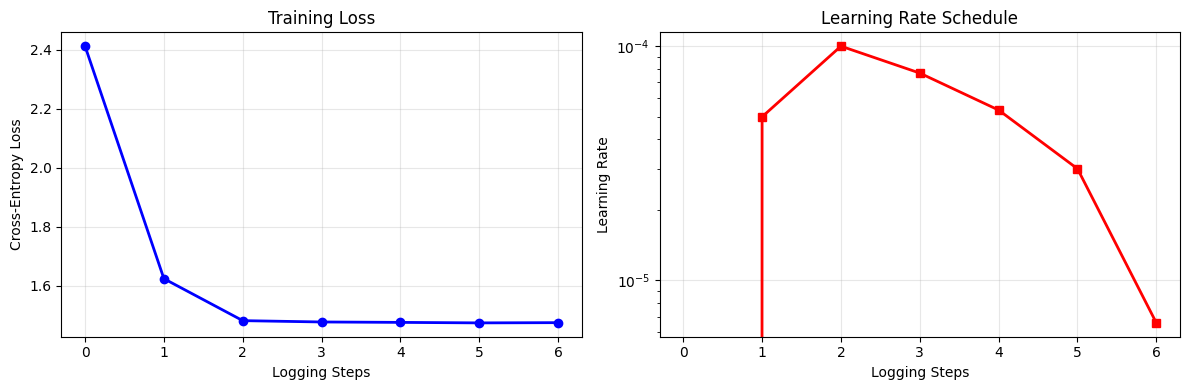

Final loss: 1.4741


In [2]:
model.train(epochs=20, batch_size=32, lr=1e-4)

## Visualization
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\
*Important:* For now we pass our test cases by hand. However in the future we will generate good inputs to test how well the model functions

/mnt/c/Users/gioke/PycharmProjects/Sysgen-GLM-for-Indels/fundemental_classes/sequence_plotter.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


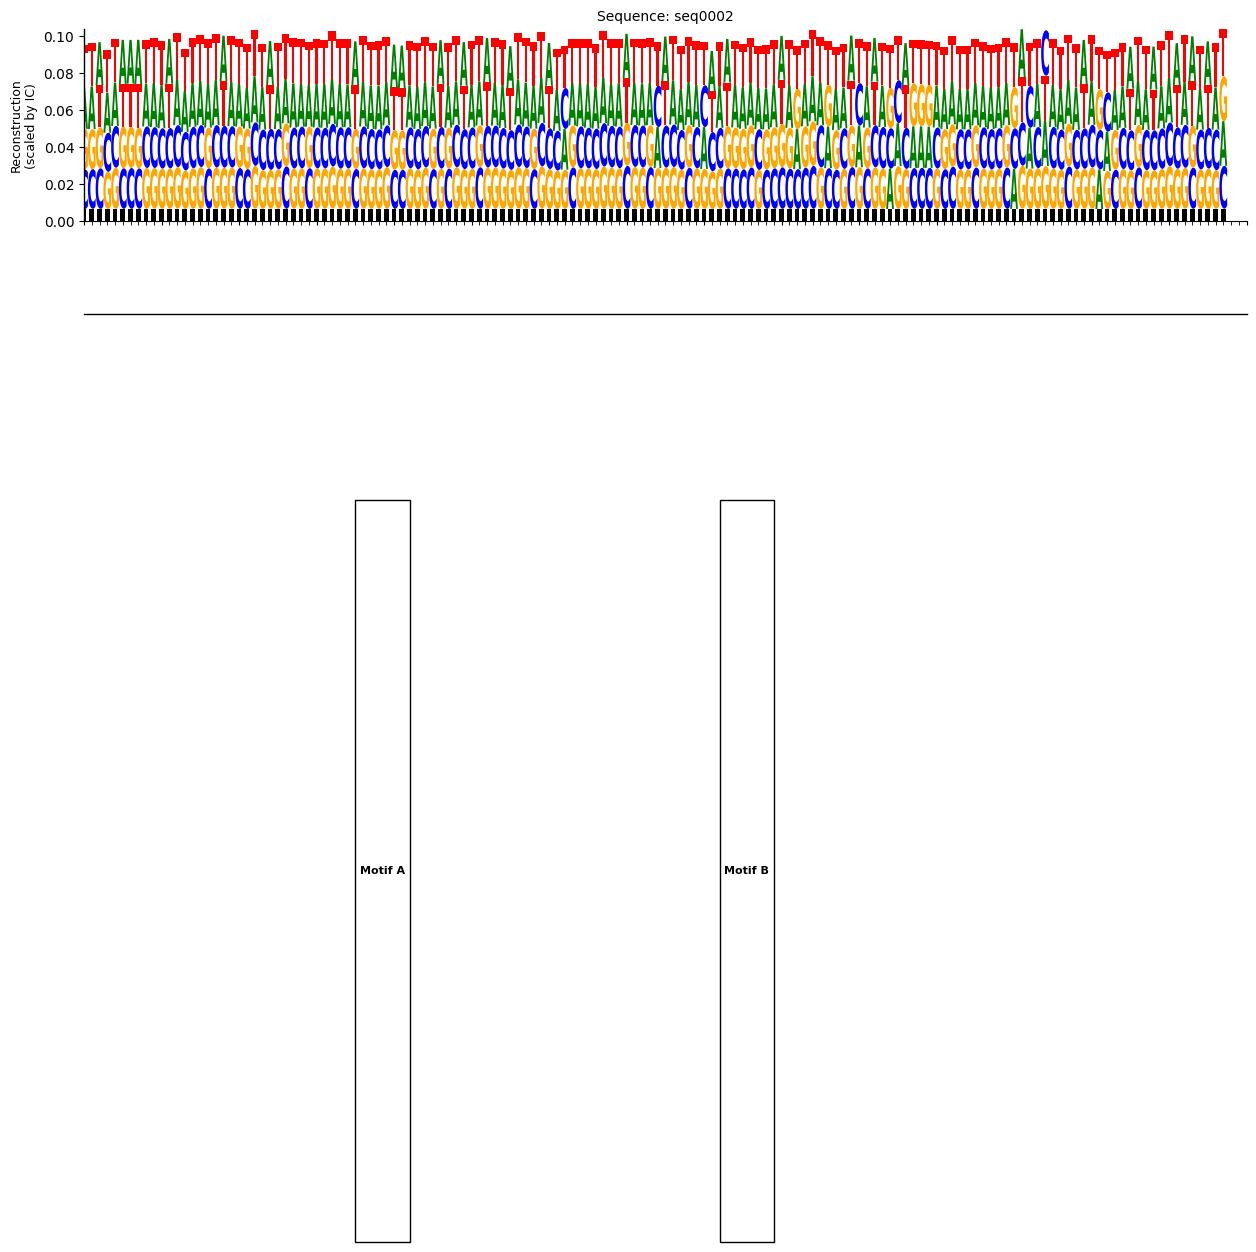

In [3]:
from fundemental_classes.sequence_plotter import SequenceLogoPlotter

plotter = SequenceLogoPlotter()

header = ">seq0002|label=both|posAmotif=35|posBmotif=82|gaplength=40|deletions=0"
sequence = "CCAACTACAAGTACCATCACGAATCGGGCGGAAAAATATTCACCTGAGACCGACTGATGCGGATGTGGTAGGCGCGACGTGCGTACTGCCGGCCTGCCCTAAACGTGAAATAACTCACTAAAAGATGCCCGCACAACTTATGATGCGAGG"

prob_matrix = model.get_full_reconstruction_probs(sequence)
plotter.plot(header, sequence, prob_matrix, motif_length=7)